# Creación del dataset ompm


Antes de nada necesitamos cargar las librerías pandas, matplotlib,networkx y el paquete nilmtk.

Asimismo realizaremos algunos otros ajustes.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import rcParams
from nilmtk.utils import print_dict
from nilmtk import DataSet
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

## Creación del fichero en formato  HDFS5 a partir de las medidas y los metadatos 

La primera tarea es la conversion de los diferentes ficheros de medidas en formato csv al formato HDFS5  (o simplificando H5), que almacenaramos en la carpeta `./data`. Además en el archivo h5, que va contener los datos recopilados,  tambien tendremos todos  los metadatos del dataset.

El timestamp arrojado por el oZM esta en  en formato 13 digitos (es decir almacena hasta los milisegundos pasados desde el 1 del 1 de 1970).El Timestamp en "timezone" para Almeria es "Europe/Madrid" https://www.epochconverter.com/

El resto de metadatos tienen que ver con la potencia (real,reactiva y aparente), el voltaje, la intensidad,la frecuencia y el factor de potencia.

Para cada fichero csv, que numeraremos del 1 al 7 corresponditntes a cada medidor (siendo el nº 1 el principal),en la clase convert_ualm,  seguimos los siguintes pasos:

- Lectura del fichero numeado

- Conversión a formato fecha del campo timestamp

- Carga del resto de columnas

- Sort index

- Resample

- Reindexacion del fichero

Obviamente la clase  lanza este proceso para todos los ficheros de datos localizados en la carpeta de entrada \electricity\  usando  el fichero labels.csv

El contenido del fichero labels.csv es el siguinte:

- 1 mains

- 2 fan

- 3 computer laptop

- 4 incandescent light 

- 5 LED light

- 6 television



Por ultimo, asociamos los metadatos correspondientes ,leyendo los ficheros de la ruta C:\Users\XXXXX\anaconda3\envs\nilmtk-env\Lib\site-packages\nilmtk\dataset_converters\ualm\metadata. 


Los ficheros que usaremos como metadatos para incorporarlos al fichero H5 son los siguintes:

 - builiding1.yaml
 
 - dataset.yaml
 
 - meter_devices.yaml



In [2]:
from nilmtk.dataset_converters import convert_ualm2
#convert_ualm2('./data/ozm2/', 'ualm2.h5','2023-02-24','2023-02-24')


Convertidos los metdatos y los datos a HDFS5, la primera tarea es la importación del dataset que se encuentra en formato HDF5 en la carpeta `./data`. Para ello, se carga el archivo dsual.h5 que contiene los datos recopilados y metadatos del dataset.

In [87]:
#dataset de referencia 
ompm = DataSet('ualm2.h5')


## MeterGroup y ElecMeter

Todos los conjuntos de datos de NILM constan de varios grupos de medidores de electricidad. 

Podemos agrupar los contadores por los siguintes criterios:
- Por viviendas en caso de haber mas viviendas por contador principal
- Por el tipo de aparato al que están conectados directamente
- Por frecuencia de muestreo
- O si el medidor es un "medidor de sitio" para toda la casa
- Si es un submedidor, a nivel de electrodomésticos, o incluso a nivel de circuito.

En NILMTK, una de las clases clave es MeterGroup, que almacena una lista de medidores y nos permite seleccionar un subconjunto de medidores, agregar energía de todos los medidores y muchas otras funciones.

Cuando abrimos por primera vez un DataSet, NILMTK crea varios objetosMeterGroup. Hay una clase llamada nilmtk.global_meter_group, la cual contiene todos los medidores cargados actualmente (incluso de varios conjuntos de datos si ha abierto más de un conjunto de datos). 

También hay un MeterGroup por edificio (que vive en el atributoBuilding.elec). También podemos anidar "MeterGroups" para agregar redes de fase dividida, red trifásica y aparatos de suministro dual (240 voltios) en conjuntos de datos de América del Norte y Canadá. 

En este punto, todos los metadatos se han cargado en la memoria pero ninguno de los datos de energía se ha cargado.
Cada edificio tiene un atributo "elec" que es un objeto "MeterGroup"y  que contiene los medidores "ElecMeter".

In [88]:
elec = ompm.buildings[1].elec #todos los medidores del dataset
elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)

Tenga en cuenta que podria haber grupos de medidores anidados: por ejemplo para un horno électrico y otro para la lavadora secadora (ambos son electrodomésticos de 240 voltios podrian tener dos medidores por electrodoméstico):

In [89]:
elec.nested_metergroups()

[]

Poner estos medidores en un grupo de medidores nos permite sumar fácilmente la demanda de energía registrada por ambos medidores para obtener la demanda de energía total para todo el aparato (pero también es muy fácil ver la demanda de energía del medidor individual).

Podemos obtener fácilmente un grupo de medidores(MeterGroup) de los submedidores o de la red.

In [90]:
elec.mains()

ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

Podemos obtener fácilmente la suma de los datos de potencia de ambos medidores de red:

In [91]:
elec.mains().power_series_all_data()

2023-02-24 14:47:10.508000+01:00    74.800003
2023-02-24 14:47:11.200000+01:00    74.800003
2023-02-24 14:47:11.881000+01:00    74.800003
2023-02-24 14:47:12.567000+01:00    74.800003
2023-02-24 14:47:13.253000+01:00    75.000000
                                      ...    
2023-02-24 20:03:51.407000+01:00    15.300000
2023-02-24 20:03:52.175000+01:00    15.300000
2023-02-24 20:03:52.961000+01:00    15.300000
2023-02-24 20:03:53.723000+01:00    15.300000
2023-02-24 20:03:54.554000+01:00    15.300000
Name: (power, active), Length: 25800, dtype: float32

Obtenemos los submedidores asociados al medidor principal

In [92]:
elec.submeters()

MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)

### Etiquetas de dispositivos

In [93]:
labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['Main', 'Fryer', 'LED Lamp',  'Incandescent lamp','Laptop Computer', 'Fan']})

Meters={}
for x in range(len(labels)): Meters[elec[x+1]]=labels['Meters'][x]
    

    

##  Metadatos

Mediante el metodo print_dict podemos explorar los metadatos asociados al Dataset

In [94]:
print_dict(ompm.metadata)  #metadatos del dataset

Asimismo podemos explorando los metadatos asociados al edificio

In [95]:
print_dict(ompm.buildings[1].metadata) #Información del edificio 1 (instancia 1)

Veamos los metadados asociados a los sinte  aparatos de medida

In [96]:
print_dict(elec[1].get_metadata()) #metadatos de ElecMeter 1 o elec[1]

print_dict(elec[2].get_metadata()) #metadatos de ElecMeter 2 o elec[2]

print_dict(elec[3].get_metadata()) #metadatos de ElecMeter 3 o elec[3]

print_dict(elec[4].get_metadata()) #metadatos de ElecMeter 4 o elec[4]

print_dict(elec[5].get_metadata()) #metadatos de ElecMeter 5 o elec[5]

print_dict(elec[6].get_metadata()) #metadatos de ElecMeter 6 o elec[6]





# Estadísticas e información para medidores individuales

La clase 'ElecMeter' representa un solo medidor de electricidad. Cada ElecMeter tiene una lista de objetos de dispositivo asociados. Cada medidor puede estar asociado a uno o más electrodomésticos.ElecMeter tiene muchos de los mismos métodos de estadísticas que MeterGroup, como 'total_energy' , 'available_power_ac_types' , 'power_series', 'power_series_all_data'. 

Ahora exploraremos algunas funciones de estadísticas más (muchas de las cuales también están disponibles en MeterGroup) .

Vamos a  estudiar el medidor asociado al hervidor de agua:

In [97]:
fan_meter = elec['fan']

Obtener el  medidor principal  superior o "de aguas arriba" (upstream meter)

In [98]:
fan_meter.upstream_meter() # happens to be the mains meter group!

ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

Metadatos sobre la clase de medidor

In [99]:
fan_meter.device

{'model': 'OZM',
 'manufacturer': 'ual',
 'manufacturer_url': 'https://openzmeter.com/',
 'description': 'Multifunction meter for feeders',
 'sample_period': 60,
 'max_sample_period': 300,
 'measurements': [{'physical_quantity': 'power',
   'type': 'active',
   'upper_limit': 10000,
   'lower_limit': 0},
  {'physical_quantity': 'frequency',
   'type': None,
   'upper_limit': 70,
   'lower_limit': 0},
  {'physical_quantity': 'voltage',
   'type': None,
   'upper_limit': 270,
   'lower_limit': 0},
  {'physical_quantity': 'pf',
   'type': None,
   'upper_limit': 1,
   'lower_limit': 0},
  {'physical_quantity': 'current',
   'type': None,
   'upper_limit': 100,
   'lower_limit': 0}]}

Aparato dominante:Si los metadatos especifican que un medidor tiene varios medidores conectados, entonces uno de ellos se puede especificar como el dispositivo 'dominante', y este dispositivo se puede recuperar con este método

In [100]:
fan_meter.dominant_appliance()

Appliance(type='fan', instance=1)

### Energia total

Algunos métodos estadísticos de MeterGroup permanecen en ElecMeter:

In [101]:
fan_meter.total_energy() # kWh

active    0.047307
dtype: float64

Podemos optar por volcar todos los datos sobre el medidor de luminarias:

In [102]:
next(fan_meter.load())

physical_quantity,voltage,power,pf,current,frequency
type,,active,,,
2023-02-24 14:47:10.508000+01:00,245.100006,0.0,0.00,0.0,50.0
2023-02-24 14:47:11.200000+01:00,245.100006,0.0,0.00,0.0,50.0
2023-02-24 14:47:11.881000+01:00,245.199997,0.0,0.00,0.0,50.0
2023-02-24 14:47:12.567000+01:00,245.199997,0.0,0.00,0.0,50.0
2023-02-24 14:47:13.253000+01:00,245.500000,0.0,0.00,0.0,50.0
...,...,...,...,...,...
2023-02-24 20:03:51.407000+01:00,245.699997,0.0,0.52,0.0,50.0
2023-02-24 20:03:52.175000+01:00,245.699997,0.0,0.52,0.0,50.0
2023-02-24 20:03:52.961000+01:00,245.699997,0.0,0.54,0.0,50.0


O cargar un generador que nos dará los valores en chunks. Más eficiente.

In [103]:
next (fan_meter.power_series())

2023-02-24 14:47:10.508000+01:00    0.0
2023-02-24 14:47:11.200000+01:00    0.0
2023-02-24 14:47:11.881000+01:00    0.0
2023-02-24 14:47:12.567000+01:00    0.0
2023-02-24 14:47:13.253000+01:00    0.0
                                   ... 
2023-02-24 20:03:51.407000+01:00    0.0
2023-02-24 20:03:52.175000+01:00    0.0
2023-02-24 20:03:52.961000+01:00    0.0
2023-02-24 20:03:53.723000+01:00    0.0
2023-02-24 20:03:54.554000+01:00    0.0
Name: (power, active), Length: 25798, dtype: float32

### Obtener buenas secciones

Si graficamos los datos de potencia sin procesar, vemos que hay una gran brecha donde, supuestamente, el sistema de medición no estaba funcionando. (si tuviéramos que acercarnos, también veríamos muchos espacios más pequeños) con light_meter.plot.Podemos identificar automáticamente las 'secciones buenas' (es decir, las secciones donde cada par de muestras consecutivas es menor que 'max_sample_period` especificado en los metadatos del conjunto de datos):

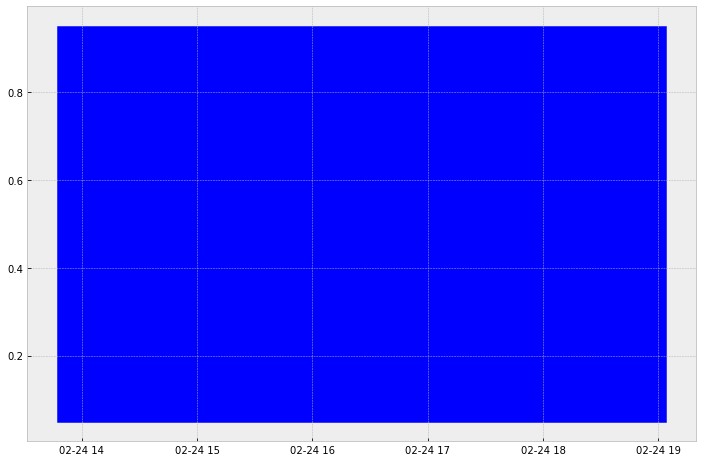

In [104]:
good_sections = fan_meter.good_sections(full_results=True)
good_sections.plot()

Los fragmentos azules muestran dónde son buenos los datos. Una brecha blanca seria en datos incompletos en los datos de potencia bruta. Teoriacamente podria habermuchos huecos más pequeños que no podemos ver en este nivel de zoom.

También podemos ver las secciones exactas identificadas:

In [105]:
good_sections.combined()

[TimeFrame(start='2023-02-24 14:47:10.508000+01:00', end='2023-02-24 20:03:54.554000+01:00', empty=False)]

## Dropout rate (tasa de deserción )

Además de que puede aparecer grandes lagunas debido a que todo el sistema está inactivo, también podemo teners pequeñas lagunas frecuentes debido a que algunos sensores  arrojan datos. A esto a veces se le llama "abandono". La tasa de abandono es un número entre 0 y 1 que especifica la proporción de muestras que faltan. Una tasa de abandono de 0 significa que no faltan muestras. Un valor de 1 significaría que faltan todas las muestras:

In [106]:
fan_meter.dropout_rate()

0.0

## Seleccion de subgrupos de medidores

Usamos ElecMeter.select_using_appliances () para seleccionar un nuevo MeterGroup usando un campo de metadatos. Por ejemplo, para obtener todas los ventiladore del conjunto de datos DSUALM::

In [107]:
import nilmtk
nilmtk.global_meter_group.select_using_appliances(type='fan')

MeterGroup(meters=
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)

O seleccione varios tipos de aparatos:

In [108]:
elec.select_using_appliances(type=['fryer', 'fan'])

MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)

O todos los electrodomésticos del edificio 1 con motor de inducción monofásico (!):

In [109]:
nilmtk.global_meter_group.select_using_appliances(building=1, category='single-phase induction motor')

MeterGroup(meters=
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)

(NILMTK importa los 'metadatos comunes' del proyecto de metadatos NILM, que incluye una amplia gama de taxonomías de diferentes categorías)(http://nilm-metadata.readthedocs.org/en/latest/central_metadata.html#appliancetype))

## Medidas disponibles para cada medidor exceptuando la potencia

In [110]:
elec.available_physical_quantities() #todas las medidas del MeterGroup

['current', 'pf', 'voltage', 'power', 'frequency']

In [111]:
elec[1].available_physical_quantities() #medidas de ElecMeter 1 (mains)



['current', 'pf', 'voltage', 'power', 'frequency']

In [112]:
elec[2].available_physical_quantities() #medidas de ElecMeter 2 (boiler)


['current', 'pf', 'voltage', 'power', 'frequency']

In [113]:
elec[3].available_physical_quantities() #medidas de ElecMeter 3 (fan)


['current', 'pf', 'voltage', 'power', 'frequency']

In [114]:
elec[4].available_physical_quantities() #medidas de ElecMeter 4 (freezer)


['current', 'pf', 'voltage', 'power', 'frequency']

In [115]:
elec[5].available_physical_quantities() #medidas de ElecMeter 5 (television)


['current', 'pf', 'voltage', 'power', 'frequency']

In [116]:
elec[6].available_physical_quantities() #medidas de ElecMeter 6 (vacuum cleaner)


['current', 'pf', 'voltage', 'power', 'frequency']

## Medidas disponibles relativas a la potencia


In [117]:
elec[1].available_ac_types('power') #medidas de potencia de ElecMeter 1 

['active']

In [118]:
elec[2].available_ac_types('power') #medidas de potencia de ElecMeter 2

['active']

In [119]:
elec[3].available_ac_types('power') #medidas de potencia de ElecMeter 3

['active']

In [120]:
elec[4].available_ac_types('power') #medidas de potencia de ElecMeter 4

['active']

In [121]:
elec[5].available_ac_types('power') #medidas de potencia de ElecMeter 5

['active']

In [122]:
elec[6].available_ac_types('power') #medidas de potencia de ElecMeter 6

['active']

Del atributo 'elec' se puede obtener información de los medidores

En caso de consultar por una medición en específico, se pueden usar los siguientes tipos de mediciones tanto en ‘available_physical_quantities’ como en ‘available_ac_types’: 'power', 'energy', 'cumulative energy', 'voltage', 'current', 'pf', 'frequency', 'power factor', 'state', 'phase angle'.

### Medidas disponibles por electrodomestico o aparato

Podemos  ver las medidas desde otro punto de vista

Veamos qué medidas tenemos para el frigorífico,hervidor,luz,tv,etc:

In [123]:
fan = elec['fan']
fan.available_columns()

[('voltage', None),
 ('power', 'active'),
 ('pf', None),
 ('current', None),
 ('frequency', None)]

In [124]:
laptop = elec['laptop computer']
laptop.available_columns()

[('voltage', None),
 ('power', 'active'),
 ('pf', None),
 ('current', None),
 ('frequency', None)]

In [125]:
lamp = elec['incandescent lamp']
lamp.available_columns()

[('voltage', None),
 ('power', 'active'),
 ('pf', None),
 ('current', None),
 ('frequency', None)]

In [126]:
LED = elec['LED lamp']
LED.available_columns()

[('voltage', None),
 ('power', 'active'),
 ('pf', None),
 ('current', None),
 ('frequency', None)]

In [127]:
fryer = elec['fryer']
fryer.available_columns()

[('voltage', None),
 ('power', 'active'),
 ('pf', None),
 ('current', None),
 ('frequency', None)]

## Resumen de mediciones

Ahora veamos un resumen de las medidas disponibles por cada medidor

In [128]:
print('Mediciones disponibles - Dataset: '+str(elec.available_physical_quantities()))
print('Mediciones de Potencia disponibles - Dataset: '+str(elec.available_ac_types('power')))

print('\nMedidas disponibles por cada medidor:')
for x in range(len(labels)):
    print(str(labels['Meters'][x])+': '+str(elec[x+1].available_physical_quantities()))

print('\nMedidas de potencia por cada medidor:')  
for x in range(len(labels)):
    print(str(labels['Meters'][x])+': '+str(elec[x+1].available_ac_types('power')))

Mediciones disponibles - Dataset: ['current', 'pf', 'voltage', 'power', 'frequency']
Mediciones de Potencia disponibles - Dataset: ['active']

Medidas disponibles por cada medidor:
Main: ['current', 'pf', 'voltage', 'power', 'frequency']
Fryer: ['current', 'pf', 'voltage', 'power', 'frequency']
LED Lamp: ['current', 'pf', 'voltage', 'power', 'frequency']
Incandescent lamp: ['current', 'pf', 'voltage', 'power', 'frequency']
Laptop Computer: ['current', 'pf', 'voltage', 'power', 'frequency']
Fan: ['current', 'pf', 'voltage', 'power', 'frequency']

Medidas de potencia por cada medidor:
Main: ['active']
Fryer: ['active']
LED Lamp: ['active']
Incandescent lamp: ['active']
Laptop Computer: ['active']
Fan: ['active']


Los dispositivos se identifican de forma única dentro de un edificio por un tipo (luces, televisión, etc.) y un número de instancia. Si no se especifica un número de instancia, ElecMeter recupera la instancia 1.

### Esquema de red

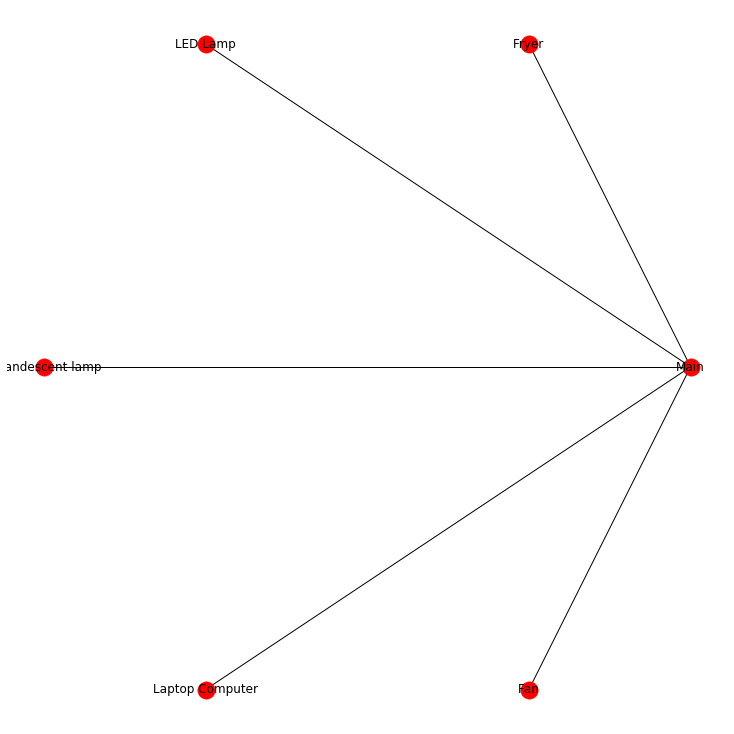

In [129]:
rcParams['figure.figsize'] = (10, 10)
fig = elec.draw_wiring_graph_2(show_meter_labels=False)

#etiquetas, opcional
pos = nx.shell_layout(fig[0])
nx.draw_networkx_labels(fig[0], pos, labels=Meters)

#guarda gráfico
plt.savefig('./data/images/2.1_Network.svg', bbox_inches='tight', transparent=True)
pass

NOTA: La funcion draw_wiring_graph  presenta problemas con Matplotlib 3.3.0 (y por tanto con NILMTK) segun issue 868 ( https://github.com/nilmtk/nilmtk/issues/868)), por lo que necesitamos reemplazar la función original para poder representar graficamente correctamente las etiquetas, por lo que vamos a crear la nueva funcion elec.draw_wiring_graph_2 que guardaremos en la ruta \user\USUARIO\anaconda3\envs\nilmtk-env\Lib\site-packages\nilmtk\metergroup.py

## Carga de datos en memoria

Intervalos de tiempo en que se registran datos: `elec[1]`

Timestamp en "timezone" es  "Europe/Madrid" https://www.epochconverter.com/

In [130]:
elec.get_timeframe()

TimeFrame(start='2023-02-24 14:47:10.508000+01:00', end='2023-02-24 20:03:54.554000+01:00', empty=False)

Una manera rápida de cargar varios datos de medidores en un DataFrame es utilizar la función `dataframe_of_meters` e indicar cual medida se desea importar desde el MeterGroup.

Observese que solo podemos tomar datos de potencia :active', 'apparent', 'reactive'.




Vamos a mostrar la potencia activa de los medidores del 2 al 6 (es decir todos menos el principal). 

In [131]:
Devices = elec.select(instance=[2,3,4,5,6])  #nuevo MeterGroup de dispositivos
df = Devices.dataframe_of_meters(ac_type='active') # active crea Dataframe badado en la potencia Valid AC types = ['active', 'apparent', 'reactive'].
#etiquetas
df.columns = [list(labels['Meters'][1:8])]
df

,Fryer,LED Lamp,Incandescent lamp,Laptop Computer,Fan
2023-02-24 14:47:00+01:00,26.129168,0.000000,48.891666,0.0,0.0
2023-02-24 14:48:00+01:00,25.980682,0.000000,20.935226,0.0,0.0
2023-02-24 14:49:00+01:00,25.947058,0.000000,0.000000,0.0,0.0
2023-02-24 14:50:00+01:00,25.738823,0.000000,0.000000,0.0,0.0
2023-02-24 14:51:00+01:00,25.782352,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...
2023-02-24 19:59:00+01:00,26.858440,0.000000,0.000000,0.0,0.0
2023-02-24 20:00:00+01:00,26.799999,0.000000,0.000000,0.0,0.0
2023-02-24 20:01:00+01:00,12.987180,5.047436,0.000000,0.0,0.0
2023-02-24 20:02:00+01:00,0.000000,10.317948,0.000000,0.0,0.0


Ahora veamos la potencia reactiva de los medidores del 2 al 6 (todos menos el principal).

Se puede obtener el tipo de datos usado para cada medidor usandola clase info

In [132]:
df.info() #información del DataFrame

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 317 entries, 2023-02-24 14:47:00+01:00 to 2023-02-24 20:03:00+01:00
Freq: 60S
Data columns (total 5 columns):
(Fryer,)                317 non-null float32
(LED Lamp,)             317 non-null float32
(Incandescent lamp,)    317 non-null float32
(Laptop Computer,)      317 non-null float32
(Fan,)                  317 non-null float32
dtypes: float32(5)
memory usage: 8.7 KB


Podemos asignar individualmente datos de medidores en un Dataframe




Vemos para el meter nº 1(main)  tenemos la siguinte tabla que nos muestra todas las medidas

In [154]:
t0 = '2023-02-24 14:47:10+01:00' #tiempo inicial
t1 = '2023-02-24 20:03:54+01:00' #tiempo final


df_main = next(elec[1].load())[t0:t1] #DataFrame medidor 
df_main

physical_quantity,voltage,power,pf,current,frequency
type,,active,,,
2023-02-24 14:47:10.508000+01:00,245.000000,74.800003,1.00,0.31,50.000000
2023-02-24 14:47:11.200000+01:00,244.899994,74.800003,1.00,0.31,50.000000
2023-02-24 14:47:11.881000+01:00,244.899994,74.800003,1.00,0.31,50.000000
2023-02-24 14:47:12.567000+01:00,244.899994,74.800003,1.00,0.31,50.000000
2023-02-24 14:47:13.253000+01:00,245.300003,75.000000,1.00,0.31,50.000000
...,...,...,...,...,...
2023-02-24 20:03:51.407000+01:00,245.600006,15.300000,0.58,0.11,49.900002
2023-02-24 20:03:52.175000+01:00,245.500000,15.300000,0.58,0.11,49.900002
2023-02-24 20:03:52.961000+01:00,245.500000,15.300000,0.58,0.11,50.000000


Se puede visualizar solo la cabecera de los datos

In [155]:
df_fr.head()

physical_quantity,voltage,power,pf,current,frequency
type,,active,,,
2023-02-24 14:47:10.508000+01:00,245.000000,74.800003,1.0,0.31,50.0
2023-02-24 14:47:11.200000+01:00,244.899994,74.800003,1.0,0.31,50.0
2023-02-24 14:47:11.881000+01:00,244.899994,74.800003,1.0,0.31,50.0
2023-02-24 14:47:12.567000+01:00,244.899994,74.800003,1.0,0.31,50.0
2023-02-24 14:47:13.253000+01:00,245.300003,75.000000,1.0,0.31,50.0


Vemos para el meter nº 2(Fryer)  tenemos la siguinte tabla que nos muestra todas las medidas

In [156]:



df_fryer = next(elec[2].load())[t0:t1] #DataFrame medidor 
df_fryer

physical_quantity,voltage,power,pf,current,frequency
type,,active,,,
2023-02-24 14:47:10.508000+01:00,245.399994,26.200001,1.0,0.11,50.000000
2023-02-24 14:47:11.200000+01:00,245.199997,26.200001,1.0,0.11,50.000000
2023-02-24 14:47:11.881000+01:00,245.199997,26.200001,1.0,0.11,50.000000
2023-02-24 14:47:12.567000+01:00,245.300003,26.200001,1.0,0.11,50.000000
2023-02-24 14:47:13.253000+01:00,245.699997,26.200001,1.0,0.11,50.000000
...,...,...,...,...,...
2023-02-24 20:03:51.407000+01:00,246.100006,0.000000,0.0,0.00,49.900002
2023-02-24 20:03:52.175000+01:00,246.000000,0.000000,0.0,0.00,50.000000
2023-02-24 20:03:52.961000+01:00,246.000000,0.000000,0.0,0.00,49.900002


Vemos para el meter nº 3(lamp)  tenemos  la siguinte tabla que nos muestra todas las medidas: 

In [157]:

df_LED = next(elec[3].load())[t0:t1] #DataFrame medidor boiler
df_LED

physical_quantity,voltage,power,pf,current,frequency
type,,active,,,
2023-02-24 14:47:10.508000+01:00,245.399994,0.0,1.00,0.00,50.000000
2023-02-24 14:47:11.200000+01:00,245.199997,0.0,1.00,0.00,50.000000
2023-02-24 14:47:11.881000+01:00,245.300003,0.0,1.00,0.00,50.000000
2023-02-24 14:47:12.567000+01:00,245.300003,0.0,1.00,0.00,50.000000
2023-02-24 14:47:13.253000+01:00,245.600006,0.0,1.00,0.00,50.000000
...,...,...,...,...,...
2023-02-24 20:03:51.407000+01:00,246.000000,10.3,0.57,0.07,50.000000
2023-02-24 20:03:52.175000+01:00,246.000000,10.3,0.57,0.07,49.900002
2023-02-24 20:03:52.961000+01:00,246.000000,10.2,0.57,0.07,49.900002


Veamos para el meter nº 4(lamp)  tenemos la siguinte tabla que nos muestra todas las medidas

In [158]:




df_lamp = next(elec[4].load())[t0:t1] #DataFrame medidor boiler
df_lamp

physical_quantity,voltage,power,pf,current,frequency
type,,active,,,
2023-02-24 14:47:10.508000+01:00,245.100006,48.900002,1.0,0.2,50.000000
2023-02-24 14:47:11.200000+01:00,245.100006,48.900002,1.0,0.2,50.000000
2023-02-24 14:47:11.881000+01:00,245.199997,48.900002,1.0,0.2,50.000000
2023-02-24 14:47:12.567000+01:00,245.199997,48.900002,1.0,0.2,50.000000
2023-02-24 14:47:13.253000+01:00,245.500000,48.900002,1.0,0.2,50.000000
...,...,...,...,...,...
2023-02-24 20:03:51.407000+01:00,245.899994,0.000000,0.0,0.0,50.000000
2023-02-24 20:03:52.175000+01:00,245.800003,0.000000,0.0,0.0,50.000000
2023-02-24 20:03:52.961000+01:00,245.800003,0.000000,0.0,0.0,50.000000


Veamos para el meter nº 5(Laptop)  tenemos la siguinte tabla que nos muestra todas las medidas

In [159]:


df_laptop = next(elec[5].load())[t0:t1] #DataFrame medidor boiler
df_laptop

physical_quantity,voltage,power,pf,current,frequency
type,,active,,,
2023-02-24 14:47:10.508000+01:00,245.000000,0.0,1.0,0.0,50.000000
2023-02-24 14:47:11.200000+01:00,245.000000,0.0,1.0,0.0,50.000000
2023-02-24 14:47:11.881000+01:00,245.000000,0.0,1.0,0.0,50.000000
2023-02-24 14:47:12.567000+01:00,245.000000,0.0,1.0,0.0,50.000000
2023-02-24 14:47:13.253000+01:00,245.399994,0.0,1.0,0.0,50.000000
...,...,...,...,...,...
2023-02-24 20:03:51.407000+01:00,245.600006,0.0,1.0,0.0,49.900002
2023-02-24 20:03:52.175000+01:00,245.600006,0.0,1.0,0.0,50.000000
2023-02-24 20:03:52.961000+01:00,245.600006,0.0,1.0,0.0,49.900002


Veamos para el ultimo meter nº 6(fan)  tenemos la siguinte tabla que nos muestra todas las medidas

In [160]:


df_fan = next(elec[6].load())[t0:t1] #DataFrame medidor boiler
df_fan

physical_quantity,voltage,power,pf,current,frequency
type,,active,,,
2023-02-24 14:47:10.508000+01:00,245.100006,0.0,0.00,0.0,50.0
2023-02-24 14:47:11.200000+01:00,245.100006,0.0,0.00,0.0,50.0
2023-02-24 14:47:11.881000+01:00,245.199997,0.0,0.00,0.0,50.0
2023-02-24 14:47:12.567000+01:00,245.199997,0.0,0.00,0.0,50.0
2023-02-24 14:47:13.253000+01:00,245.500000,0.0,0.00,0.0,50.0
...,...,...,...,...,...
2023-02-24 20:03:51.407000+01:00,245.699997,0.0,0.52,0.0,50.0
2023-02-24 20:03:52.175000+01:00,245.699997,0.0,0.52,0.0,50.0
2023-02-24 20:03:52.961000+01:00,245.699997,0.0,0.54,0.0,50.0


### Proporcion de energia submedida

Calculemos la proporción de energía submedida en el edificio 1:

In [161]:
elec.proportion_of_energy_submetered()

Running MeterGroup.proportion_of_energy_submetered...


0.9520219741267745

Tenga en cuenta que NILMTK ha emitido una advertencia de que Mains usa un tipo diferente de medición de potencia que todos los submedidores, por lo que no es una comparación del todo precisa. Lo que plantea la pregunta: ¿qué tipo de medidas de potencia se utilizan para la red y los submedidores? Vamos a averiguar.

### Carga una columna simple de datos de  potencia

Usar fan.power_series() que devuelve un generador de objetos pandas.Series unidimensionales, cada uno de los cuales contiene datos de energía utilizando el tipo de CA más 'sensible':

In [162]:
series = next(fan.power_series())
series.head()

2023-02-24 14:47:10.508000+01:00    0.0
2023-02-24 14:47:11.200000+01:00    0.0
2023-02-24 14:47:11.881000+01:00    0.0
2023-02-24 14:47:12.567000+01:00    0.0
2023-02-24 14:47:13.253000+01:00    0.0
Name: (power, active), dtype: float32

### Especificar cantidad_física o tipo de CA

Para cargar datos de voltaje:

In [163]:
df = next(fan.load(physical_quantity='voltage'))
df.head()

physical_quantity,voltage
type,
2023-02-24 14:47:10.508000+01:00,245.100006
2023-02-24 14:47:11.200000+01:00,245.100006
2023-02-24 14:47:11.881000+01:00,245.199997
2023-02-24 14:47:12.567000+01:00,245.199997
2023-02-24 14:47:13.253000+01:00,245.500000


In [164]:
df = next(fan.load(physical_quantity = 'power'))
df.head()

physical_quantity,power
type,active
2023-02-24 14:47:10.508000+01:00,0.0
2023-02-24 14:47:11.200000+01:00,0.0
2023-02-24 14:47:11.881000+01:00,0.0
2023-02-24 14:47:12.567000+01:00,0.0
2023-02-24 14:47:13.253000+01:00,0.0


### Cargando especificando el tipo de CA

In [165]:
df = next(fan.load(ac_type='active'))
df.head()

physical_quantity,power
type,active
2023-02-24 14:47:10.508000+01:00,0.0
2023-02-24 14:47:11.200000+01:00,0.0
2023-02-24 14:47:11.881000+01:00,0.0
2023-02-24 14:47:12.567000+01:00,0.0
2023-02-24 14:47:13.253000+01:00,0.0


### Cargando por remuestreo a un período específico

In [166]:
# resample por minutos (i.e. con un simple periodo de  60 secs)
df = next(fan.load(ac_type='active', sample_period=60))
df.head()

physical_quantity,power
type,active
2023-02-24 14:47:00+01:00,0.0
2023-02-24 14:48:00+01:00,0.0
2023-02-24 14:49:00+01:00,0.0
2023-02-24 14:50:00+01:00,0.0
2023-02-24 14:51:00+01:00,0.0


# Estadisticas para MeterGroups

Calculemos la proporción de energía submedida en el edificio 1 

In [167]:
elec.proportion_of_energy_submetered()

Running MeterGroup.proportion_of_energy_submetered...


0.9520219741267745

## Potencia activa

In [168]:
mains = elec.mains()
mains.available_ac_types('power')
elec.submeters().available_ac_types('power')
next(elec.load())

Loading data for meter ElecMeterID(instance=6, building=1, dataset='DSUAL')     
Done loading data all meters for this chunk.


physical_quantity,power,voltage,pf,current,frequency
type,active,NaN,NaN,NaN,NaN
2023-02-24 14:47:00+01:00,149.777771,NaN,NaN,NaN,NaN
2023-02-24 14:48:00+01:00,94.179550,NaN,NaN,NaN,NaN
2023-02-24 14:49:00+01:00,51.823528,NaN,NaN,NaN,NaN
2023-02-24 14:50:00+01:00,51.397644,NaN,NaN,NaN,NaN
2023-02-24 14:51:00+01:00,51.484703,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-02-24 19:59:00+01:00,53.783115,NaN,NaN,NaN,NaN
2023-02-24 20:00:00+01:00,53.669228,NaN,NaN,NaN,NaN
2023-02-24 20:01:00+01:00,38.561539,NaN,NaN,NaN,NaN


### Energia Total

In [169]:
elec.mains().total_energy() # returns kWh

active    0.338637
dtype: float64

In [170]:
#energía por submedidor kwH diaria promedio
d1=elec.energy_per_meter(ac_type=['active'], per_period='D').round(2) # kWh, per_period='D'
#energía por submedidor kwH semanal promedio
d2=elec.energy_per_meter(ac_type=['active'], per_period='W').round(2) # kWh, per_period='W'
#energía por submedidor kwH total
d3=elec.energy_per_meter(ac_type=['active'], per_period='M').round(2) # kWh, per_period='D'

#df=d1.append([d2,d3]).drop(index=['apparent', 'reactive']).transpose()

df=d1.append([d2,d3]).drop(index=['apparent', 'reactive']).transpose()


df.index = [list(labels['Meters'])]
df.columns = ['kWh Día','kWh Sem.','kwh Mens']
df

6/6 ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])nstance=1)])])

,kWh Día,kWh Sem.,kwh Mens
Main,1.54,10.78,47.73
Fryer,0.40,2.77,12.27
LED Lamp,0.27,1.90,8.40
Incandescent lamp,0.46,3.22,14.25
Laptop Computer,0.12,0.87,3.85
Fan,0.22,1.51,6.67


### Energia por submedidor

Veamos la energia  para el submedidor

In [171]:
energy_per_meter = elec.submeters().energy_per_meter() # kWh, again
energy_per_meter

5/5 ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])nstance=1)])])

,"(2, 1, DSUAL)","(3, 1, DSUAL)","(4, 1, DSUAL)","(5, 1, DSUAL)","(6, 1, DSUAL)"
active,0.087072,0.05962,0.101081,0.027309,0.047307
apparent,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN


Los encabezados de columna son los números de instancia de ElecMeter.

La funcion `fraction_per_meter` lo mismo que `energy_per_submeter` excepto que devuelve la fraccion de energia por medidor

Seleccionar contadores en función de su consumo energético

Hagamos un nuevo MeterGroup que solo contenga los ElecMeters que usaron más de 20 kWh:

In [172]:
# energy_per_meter es un DataFrame donde cada fila es un
# tipo de potencia ('activa', 'reactiva' o 'aparente').
# Todos los medidores de electrodomésticos en REDD están registrados como 'activos', así que seleccione
# la fila 'activa':
energy_per_meter = energy_per_meter.loc['active']
more_than_20 = energy_per_meter[energy_per_meter > 20]
more_than_20

Series([], Name: active, dtype: float64)

In [173]:
instances = more_than_20.index
instances

Index([], dtype='object')

### Trazar la fracción del consumo de energía de cada aparato

In [174]:
fraction = elec.submeters().fraction_per_meter().dropna()

5/5 ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])nstance=1)])])

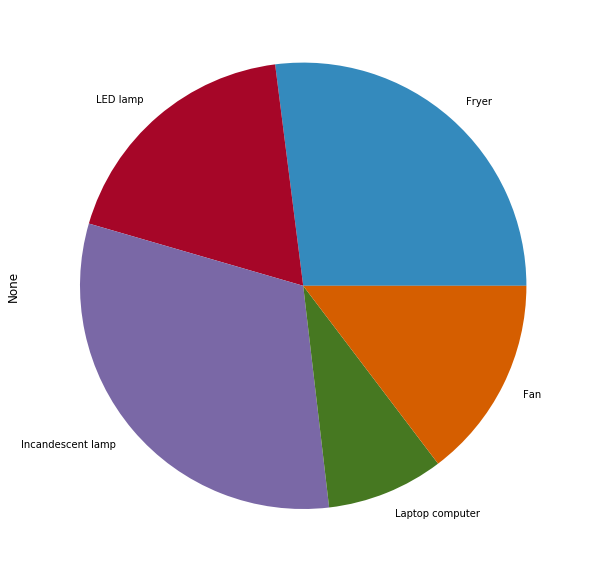

In [175]:
# Creacion de convenientes etiquetas
labels = elec.get_labels(fraction.index)
plt.figure(figsize=(10,30))
fraction.plot(kind='pie', labels=labels);

## Gráficos

### Fan

Veamos ahora en forma de grafico las potencia,frecuencia, la tension y la corriente para el medidor numero 2 Primero veamos el timeframe.

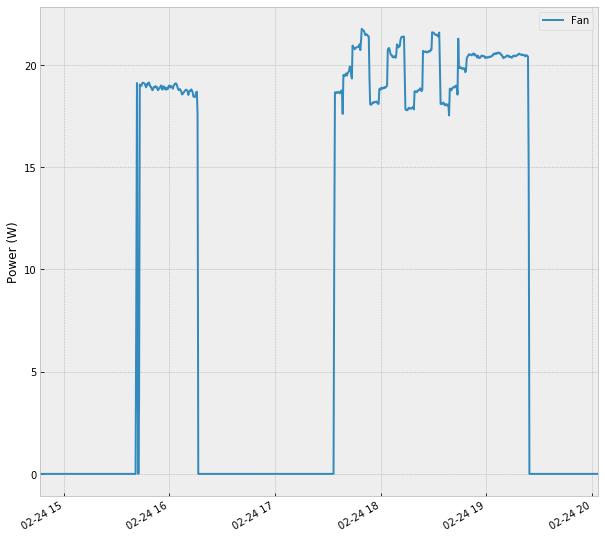

In [176]:
fan.get_timeframe()
fan.plot()

Ahora vamos a mostrar los diferentes de la potencia, tension y corriente

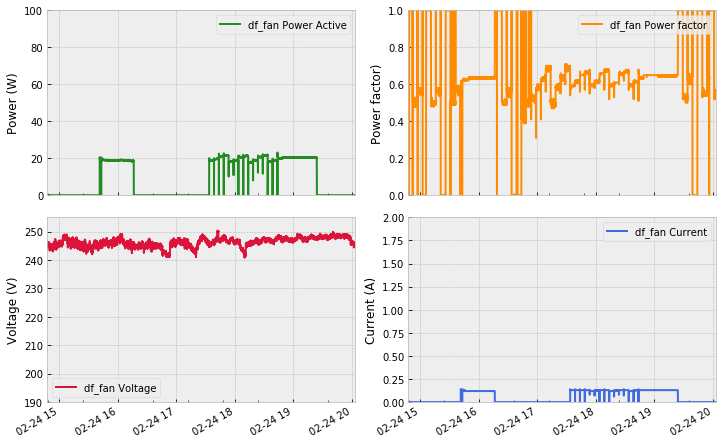

In [177]:
df_fan = next(elec[6].load()) #DataFrame medidor 



df_vac = next(elec[5].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_fan['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_fan Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,100])

df_fan['pf'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_fan Power factor'])
ax2.set(ylabel='Power factor)')
ax2.set_ylim([0,1])

df_fan['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_fan Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_fan['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_fan Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,2])




#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass



### Laptop

Veamos ahora en forma de grafico las potencias activa y reactiva junto a la tension y la corriente para el medidor numero 3 (Laptop)

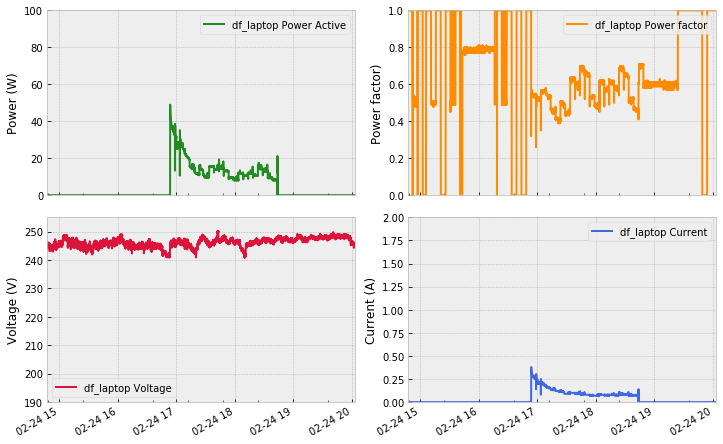

In [178]:



df_laptop = next(elec[5].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_laptop['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_laptop Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,100])

df_laptop['pf'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_laptop Power factor'])
ax2.set(ylabel='Power factor)')
ax2.set_ylim([0,1])

df_laptop['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_laptop Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_laptop['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_laptop Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,2])




#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass




### Lamp

Veamos ahora en forma de grafico las potencias activa y reactiva junto a la tension y la corriente para el medidor numero 4 (Incandescent lamp)

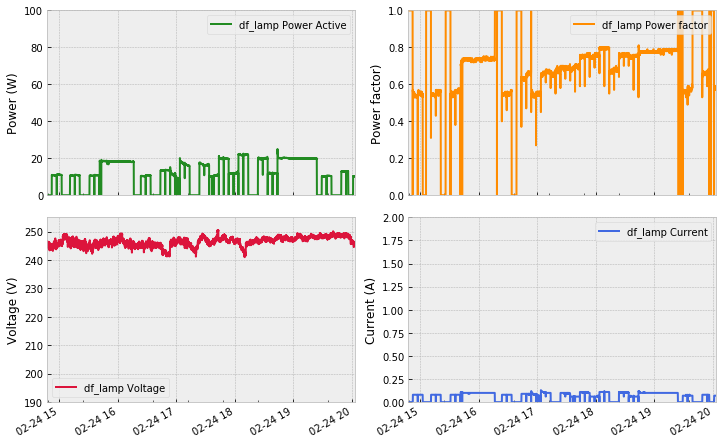

In [179]:



df_lamp = next(elec[3].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_lamp['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_lamp Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,100])

df_lamp['pf'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_lamp Power factor'])
ax2.set(ylabel='Power factor)')
ax2.set_ylim([0,1])

df_lamp['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_lamp Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_lamp['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_lamp Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,2])




#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass









### LED

Veamos ahora en forma de grafico las potencias activa y reactiva junto a la tension y la corriente para el medidor numero 5 (lED Light)

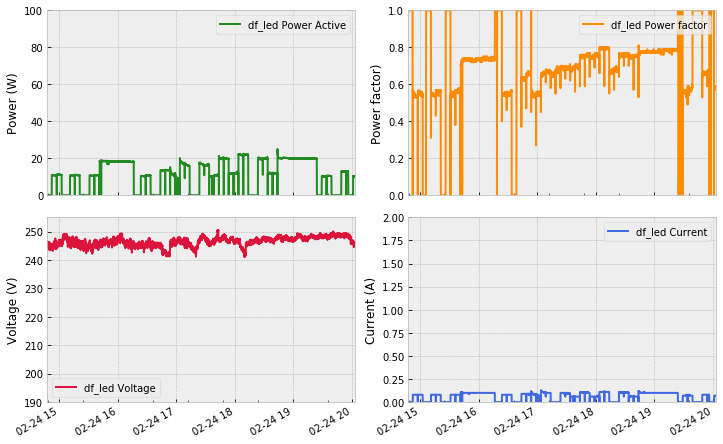

In [180]:

df_led = next(elec[3].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_led['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_led Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,100])

df_led['pf'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_led Power factor'])
ax2.set(ylabel='Power factor)')
ax2.set_ylim([0,1])

df_led['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_led Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_led['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_led Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,2])


#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass



### Fryer

Veamos ahora en forma de grafico las potencias activa y reactiva junto a la tension y la corriente para el medidor numero 6 (tv)

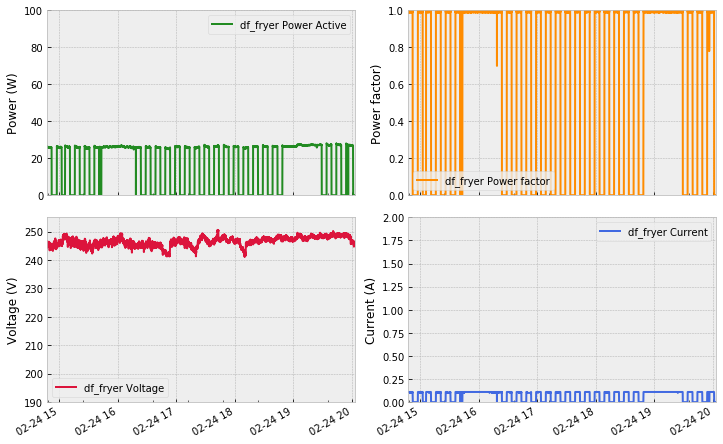

In [181]:

df_fr = next(elec[2].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_fr['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_fryer Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,100])

df_fr['pf'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_fryer Power factor'])
ax2.set(ylabel='Power factor)')
ax2.set_ylim([0,1])

df_fr['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_fryer Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_fr['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_fryer Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,2])


#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass



Vemos el comportamiento de un pequeño ventilador cuyo consumo es casi inapreciable y no presenta energia reaciva. Es llamativo el hecho de que haya fluctuaciones apreciables en la grafica de la tension asi como  tambien un pequeño pico de corriente ( este hecho solo en el momento del arranque). 

### M.Principal

Por ultimo veamos ahora en forma de grafico las potencias activa y reactiva junto a la tension y la corriente para el medidor numero 5 (TV)

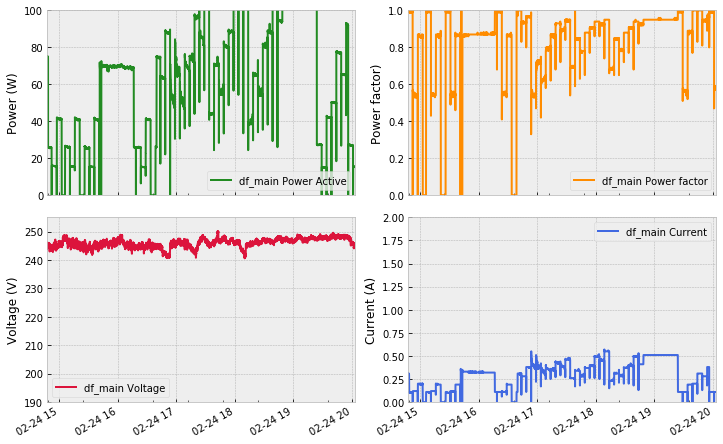

In [182]:



df_main = next(elec[1].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_main['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_main Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,100])

df_main['pf'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_main Power factor'])
ax2.set(ylabel='Power factor)')
ax2.set_ylim([0,1])

df_main['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_main Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_main['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_main Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,2])


#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass




Por ultimo vemos la grafica de un monitor cuyos resultado arroja tanto potencia activa como reactiva  ( por la fuente conmutada) pero ninguna fluctuacion en la tension ni en en la corriente 

### Trazar los electrodomésticos cuando estén en uso

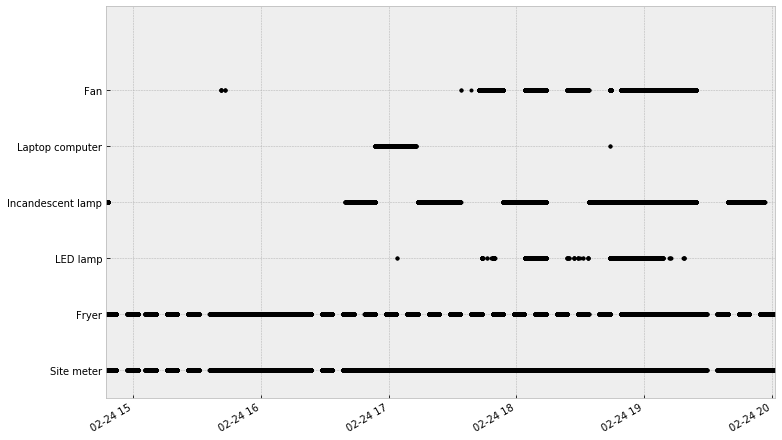

In [183]:
#sns.set_palette("Set3", n_colors=12)
# Set a threshold to remove residual power noise when devices are off
elec.plot_when_on(on_power_threshold = 20)

## Trazar datos submedidos para un solo día

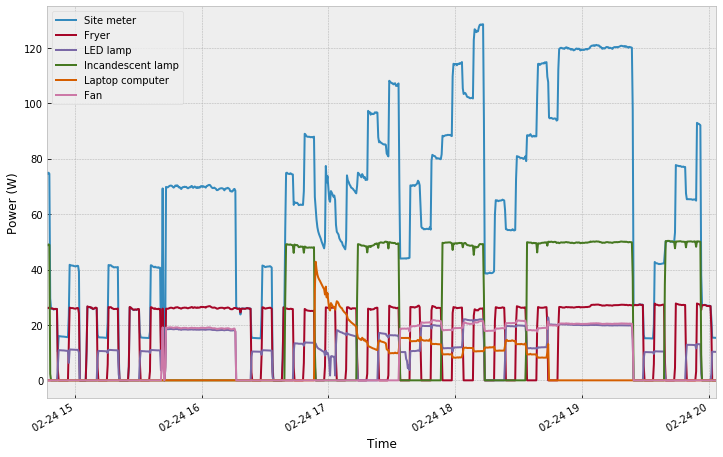

In [184]:
ompm.set_window(start='2023-02-24', end='2023-02-25')
elec.plot();
ax1.set_xticklabels(['1','2','3','4','5','6','7'])
plt.xlabel("Time");

## Gráfico de autocorrelación

In [185]:
from pandas.plotting import autocorrelation_plot

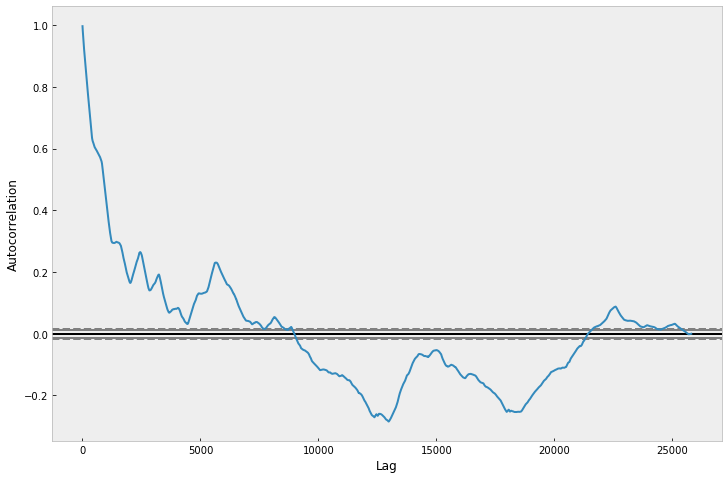

In [186]:
elec.mains().plot_autocorrelation();

## Cambio en el muestreo de datos

Al cambiar el muestro de datos, NILMTK utiliza por defecto el método mean o media aritmética el cual calculará un promedio de los valores que se encuentren de la serie de tiempo, divididos en grupos correspondientes al nuevo periodo de muestreo. Además de este método se pueden especificar otros tales como el primer dato válido (first), la mediana (median), el valor más cercano (nearest), o utilizar el valor inmediatamente posterior (ffill o pad), entre otros.

### Energia activa

Vamos ahora analizar la potencia  activa correspondiente el contador global  usando diferentes periodos de muestreo

In [187]:
m = 1 #meter
method1 = {'how': 'mean'}
method2 = {'how': 'median'}
method3 = {'how': 'first'}

#medición original, cada 1 segundo
df_1s   = next(elec[m].load(ac_type='active',sample_period=1,       resample_kwargs=method1))
#resamples
df1_10s  = next(elec[m].load(ac_type='active', sample_period=10,     resample_kwargs=method1))
df1_30s  = next(elec[m].load(ac_type='active', sample_period=30,     resample_kwargs=method1))
df1_60s  = next(elec[m].load(ac_type='active', sample_period=60*1,   resample_kwargs=method1))
df1_5m   = next(elec[m].load(ac_type='active', sample_period=60*5,   resample_kwargs=method1))
df1_10m  = next(elec[m].load(ac_type='active', sample_period=60*10,  resample_kwargs=method1))
df1_15m  = next(elec[m].load(ac_type='active', sample_period=60*15,  resample_kwargs=method1))
df1_30m  = next(elec[m].load(ac_type='active', sample_period=60*30,  resample_kwargs=method1))

df2_10s  = next(elec[m].load(ac_type='active', sample_period=10,    resample_kwargs=method2))
df2_30s  = next(elec[m].load(ac_type='active', sample_period=30,    resample_kwargs=method2))
df2_60s  = next(elec[m].load(ac_type='active', sample_period=60*1,  resample_kwargs=method2))
df2_5m   = next(elec[m].load(ac_type='active', sample_period=60*5,  resample_kwargs=method2))
df2_10m  = next(elec[m].load(ac_type='active', sample_period=60*10,  resample_kwargs=method2))
df2_15m  = next(elec[m].load(ac_type='active', sample_period=60*15,  resample_kwargs=method2))
df2_30m  = next(elec[m].load(ac_type='active', sample_period=60*30,  resample_kwargs=method2))

df3_10s  = next(elec[m].load(ac_type='active', sample_period=10,    resample_kwargs=method3))
df3_30s  = next(elec[m].load(ac_type='active', sample_period=30,    resample_kwargs=method3))
df3_60s  = next(elec[m].load(ac_type='active', sample_period=60*1,  resample_kwargs=method3))
df3_5m   = next(elec[m].load(ac_type='active', sample_period=60*5,  resample_kwargs=method3))
df3_10m  = next(elec[m].load(ac_type='active', sample_period=60*10,  resample_kwargs=method3))
df3_15m  = next(elec[m].load(ac_type='active', sample_period=60*15,  resample_kwargs=method3))
df3_30m  = next(elec[m].load(ac_type='active', sample_period=60*30,  resample_kwargs=method3))

#dataframe completo
dfs1=[df_1s,df1_10s,df1_30s,df1_60s,df1_5m,df1_10m,df1_15m,df1_30m]
#dataframe completo
dfs2=[df_1s,df2_10s,df2_30s,df2_60s,df2_5m,df2_10m,df2_15m,df2_30m]
#dataframe completo
dfs3=[df_1s,df3_10s,df3_30s,df3_60s,df3_5m,df3_10m,df3_15m,df3_30m]

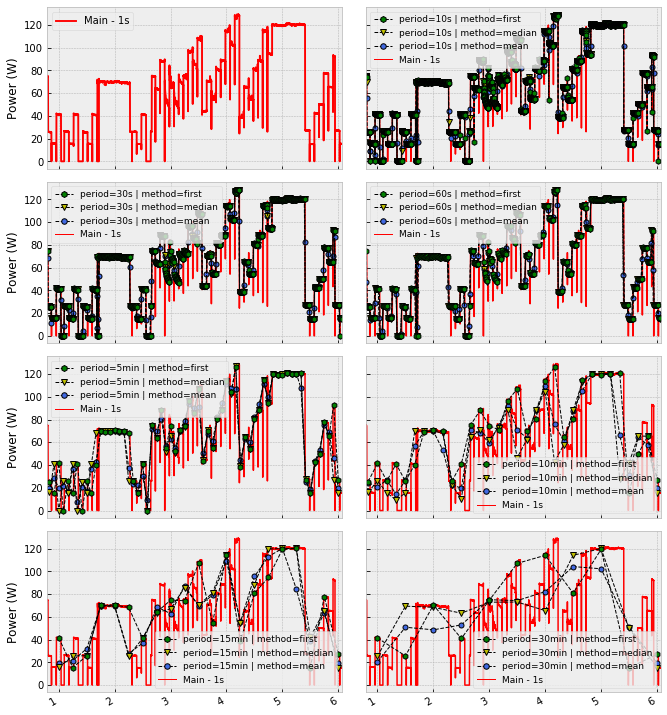

In [188]:
rcParams['figure.figsize'] = (11, 14)



labels_ = ['Main - 1s','10s','30s','60s','5min','10min','15min','30min']
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2, sharex=True, sharey=True,
                                                                   gridspec_kw={'hspace': 0.08, 'wspace': 0.08})
i = 1
for ax in fig.get_axes():   
    if ax == ax1:
        df_1s[t0:t1].plot(ax=ax,linewidth=1.9,color='r')
        ax.legend([labels_[0]])               
    else:
        import matplotlib.lines as mlines
        df_1s[t0:t1].plot(ax=ax,linewidth=1.5,color='r') 
        dfs1[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="o", markersize=5, markerfacecolor='royalblue')    
        dfs2[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="v", markersize=5.5, markerfacecolor='y')
        dfs3[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="h", markersize=5.5, markerfacecolor='g')
        #etiquetas
        line0 = mlines.Line2D([], [], lw=1, c='red', label= labels_[0])
        line1 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="o", markersize=5.5,
                              markerfacecolor='royalblue', label='period='+labels_[i]+' | method=mean')
        line2 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="v", markersize=6,
                              markerfacecolor='y', label='period='+labels_[i] + ' | method=median')
        ax.legend(handles=[line2, line1, line0], fontsize=9)
        line3 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="h", markersize=6,
                              markerfacecolor='g', label='period='+labels_[i] + ' | method=first')
        ax.legend(handles=[line3, line2, line1, line0], fontsize=9)
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
        i = i+1
    ax.set(ylabel='Power (W)')


ax1.minorticks_off()
ax1.set_xticklabels(['1','2','3','4','5','6','7'])

#guarda gráfico
plt.savefig('./data/images/2.3_Resample.svg', bbox_inches='tight', transparent=True)
pass